In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc
import numpy as np
import matplotlib.pyplot as plt
import os
import nept

In [2]:
#Get manual clustering results using Hung-tu's code
from loader_mclust import load_spikes
file_path = 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/'
units = load_spikes(file_path)
sampling_frequency = 30000

# Let's concatenate all the units with unique per each unit labels
# into numpy arrays and pass it all to NumpySortingExtractor
all_times = []
all_labels = []
units_map = []
for u_index, u in enumerate(units):
    all_times += [u.time]
    all_labels += [u_index] * len(u.time)
    units_map.append(u.label)
all_times = np.hstack(all_times)
all_labels = np.hstack(all_labels)
assert all_times.ndim == 1
assert all_times.shape == all_labels.shape

# Convert spike times to spike indices
lfp = nept.load_lfp('data/BiconditionalOdor/M040-2020-04-29-CDOD12/CSC11.ncs')

# Method 1
reader = neo.NeuralynxIO(dirname='data/BiconditionalOdor/M040-2020-04-29-CDOD12')
recordingList = [se.NeuralynxRecordingExtractor(dirname='data/BiconditionalOdor/M040-2020-04-29-CDOD12', seg_index=i) for i in range(reader.segment_count(0))]
# This concatenates mutiple segments together
recordingFull = se.MultiRecordingTimeExtractor(recordingList)
all_times_1 = np.array([np.round(recordingFull.time_to_frame(x)) for x in all_times-lfp.time[0]], dtype=np.int64)

# # Method 2
# all_times_2 = np.searchsorted(lfp.time, all_times)

# print(np.where(all_times_1 != all_times_2)[0].size)

mclust_res = se.NumpySortingExtractor()
mclust_res.set_times_labels(times=all_times_1, labels=all_labels )
mclust_res.set_sampling_frequency(sampling_frequency=sampling_frequency)

In [3]:
# Getting all the results directory
results_top_dir = 'data/Kilosort2_results/M040-2020-04-29-CDOD12/'
subdirs = [os.path.join(results_top_dir, dirname) for dirname in os.listdir(results_top_dir) if os.path.isdir(os.path.join(results_top_dir,dirname))]

In [4]:
# Looping through results to see if at least one unit matches
first_pass_candidates = {}
funny_business = {}
max_agreement_scores = {}

for dirname in subdirs:
    # Using PhySortingExtractor because Kilosort2 results are exported in the Phy format
    this_key = "_".join(dirname.split("_")[-2:])
    this_ksr = se.PhySortingExtractor(folder_path=dirname)
    this_com = sc.compare_two_sorters(sorting1=this_ksr, sorting2=mclust_res)
    #Saving this to see what kind of values pop out
    max_agreement_scores[this_key] = this_com.agreement_scores.max()
    # Check if even 1 unit matches, if it does add the comparsion and the sorting to the first_pass_candidates dictionary
    this_ks_map = this_com.get_mapped_sorting1()
    matches = [x for x in this_ks_map.get_mapped_unit_ids() if x != -1]
    if len(matches) == 0: # no matches found
        #this is just a sanity check, probably unnecessary
        matches2 = [x for x in this_com.get_mapped_sorting2().get_mapped_unit_ids() if x != -1]
        if len(matches2) != 0:
            #append to funny_business
            print(this_key, " : Funny business!\n")
            funny_business[this_key] = [this_ksr, this_com]
    else:
        print(this_key, " Number of matched units: ", len(matches))
        first_pass_candidates[this_key] = [this_ksr, this_com]

In [5]:
# Really low agreement score even for the max value
# No matches found from the above iteration
max_max = [(a, max_agreement_scores[a].max()) for a in max_agreement_scores]
# Need to investigate what's happening
# max_agreement_scores['16_8']
max_max

[('10_4', 0.04751908779383179),
 ('10_5', 0.04758275970982087),
 ('11_4', 0.0502054805473085),
 ('11_5', 0.04903701396459534),
 ('12_4', 0.05346746747899595),
 ('12_5', 0.05344878208855549),
 ('12_6', 0.05452471842388285),
 ('13_4', 0.0541696864844645),
 ('13_5', 0.05506935123042506),
 ('13_6', 0.05418661615718737),
 ('14_4', 0.053236163896502015),
 ('14_5', 0.05320288550296869),
 ('14_6', 0.05270241353290311),
 ('14_7', 0.053300317793588216),
 ('15_4', 0.0552895549543942),
 ('15_5', 0.05585889812750915),
 ('15_6', 0.05530221424296828),
 ('15_7', 0.05589695897688385),
 ('16_4', 0.057864829687946415),
 ('16_5', 0.057857378672829314),
 ('16_6', 0.057865461056855846),
 ('16_7', 0.05786929707001353),
 ('16_8', 0.057915033385640684),
 ('17_4', 0.05694380684144571),
 ('17_5', 0.05694235029131997),
 ('17_6', 0.05699494730046803),
 ('17_7', 0.05697082557417753),
 ('17_8', 0.05699449682604753),
 ('18_4', 0.05523523656639152),
 ('18_5', 0.05527390107281876),
 ('18_6', 0.05527437779529204),
 ('18

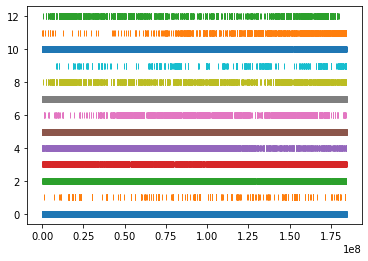

In [15]:
fig,ax = plt.subplots()
uids = mclust_res.get_unit_ids()
for i in range(len(uids)):
    st = mclust_res.get_unit_spike_train(uids[i])
    ax.plot(st, np.repeat(i, st.size), '|')
ksr_1 =  se.PhySortingExtractor(folder_path='data/Kilosort2_results/M040-2020-04-29-CDOD12/results_16_8')
st2 = ksr_1.get_unit_spike_train(6)
ax.plot(st2, np.repeat(len(uids), st2.size), '|')

In [46]:
# ksr_1.get_unit_property_names()
# uids = ksr_1.get_unit_ids()
# q = [ksr_1.get_unit_property(x, 'KSLabel') for x in uids]
# len(ksr_1.get_units_property(property_name='KSLabel'))

In [18]:
# # units matched to ks2 units
# ksort1_map = com4.get_mapped_sorting1()
# print('Ksort2 units:', ksr_1.get_unit_ids())
# print('Ksort2 mapped units:', ksort1_map.get_mapped_unit_ids())

# # units matched to msort units
# mclust_map = com4.get_mapped_sorting2()
# print('Mclust units:', msort.get_unit_ids())
# print('Mclust mapped units:', mclust_map.get_mapped_unit_ids())